<a href="https://colab.research.google.com/github/AlirezaPNouri/BERTEmbedding/blob/main/Storytelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Author: ALireza P. Nouri
Supervisor: Prof. M. Shahriar Hossain
link to the dataset
https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/NYTimes_1500Artcles_2017.csv
'''

'\nAuthor: ALireza P. Nouri\nSupervisor: Prof. M. Shahriar Hossain\nlink to the dataset\nhttps://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/NYTimes_1500Artcles_2017.csv\n'

In [2]:
# to check if the GPU is ready to use
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
# to tell pytorch that we are going to use GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [4]:
!pip install transformers

In [5]:
!pip install wget

In [6]:
# download the dataset as a zip file
import wget
import os
import requests
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/NYTimes_1500Artcles_2017.csv'
res = requests.get(url, allow_redirects=True)
with open('small_dataset_NYT.csv','wb') as file:
    file.write(res.content)
print('Download is done!')

Download is done!


In [10]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1,  )
df = df.dropna(how='any', axis=0)
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df = df[0:100]
# Display 10 random rows from the data.
print(df.columns)
df.sample(10)
new_df = df[[0, 4]]
new_df.columns = ['id', 'content']
new_df.head()

Number of training sentences: 1,485

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


,id,content
0,17283,WASHINGTON — Congressional Republicans have a ...
1,17284,"After the bullet shells get counted, the blood..."
2,17285,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Death may be the great equalizer, but it isn’t..."
4,17287,"SEOUL, South Korea — North Korea’s leader, Kim..."


In [11]:
data = new_df[new_df.content.str.contains("Trump")]
data.shape[0]
data.sample


<bound method NDFrame.sample of         id                                            content
0    17283  WASHINGTON — Congressional Republicans have a ...
4    17287  SEOUL, South Korea — North Korea’s leader, Kim...
6    17289  BEIJING — President Tsai Ing-wen of Taiwan sha...
10   17293  With Donald J. Trump about to take control of ...
11   17294  THOMPSONS, Tex. — Can one of the most promisin...
12   17295  WEST PALM BEACH, Fla. — When President-elect D...
17   17301  MUMBAI, India — It was a bold and risky gamble...
24   17309  WASHINGTON — The most powerful and ambitious R...
25   17311  WASHINGTON — It’s put-up or shut-up time for R...
26   17312  Good morning.  Here’s what you need to know: •...
27   17313  The body of the Iraqi prisoner was found naked...
29   17317  WASHINGTON — President Obama’s advisers wrestl...
31   17319  JERUSALEM — Israeli police investigators quest...
36   17326  In the basement of a mammoth old building in U...
39   17330  WASHINGTON — It was suppos

In [62]:
sentences = data.content.values
labels = data.id.values
print(sentences.shape)
print(labels.shape)
print(type(labels))
data
temp = labels.shape[0]
labels =np.array(list(range(0,temp)))
print(labels)

(46,)
(46,)
<class 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [65]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [66]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  WASHINGTON — Congressional Republicans have a new fear when it comes to their two-year-old health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for low- and moderate-income Americans, handing House Republicans a big victory on separation-of-power issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health c

In [67]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  WASHINGTON — Congressional Republicans have a new fear when it comes to their two-year-old health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for low- and moderate-income Americans, handing House Republicans a big victory on separation-of-power issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health ca

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [68]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))


Max sentence length:  256


In [69]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [70]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct 

In [71]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [73]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = temp, # The number of output labels--2 for binary classification. # here temp is the size of the dataset
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [74]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [75]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [76]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 40

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [77]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [78]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [79]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    embedding_layers = []
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        print(batch[2].shape)
        print(batch[1].shape)
        print(batch[0].shape)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # print(len(outputs))
        # print(outputs[0]) the loss
        # print(len(outputs[1])) the batches
        # print(len(outputs[2])) the embedding layers
        # import numpy as np
        # print(np.shape(outputs[2]))--->(13,)
        # print(np.shape(outputs[2][1])) --->torch.Size([32, 64, 768]) the embedding in the layer one
        # print(np.shape(outputs[2][2]))--->torch.Size([32, 64, 768]) the embedding in the layer two
        # print(len(outputs[2][3]))
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        


======== Epoch 1 / 40 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([9])
torch.Size([9, 256])
torch.Size([9, 256])

  Average training loss: 3.89
  Training epcoh took: 0:00:04

======== Epoch 2 / 40 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([9])
torch.Size([9, 256])
torch.Size([9, 256])

  Average training loss: 3.80
  Training epcoh took: 0:00:03

======== Epoch 3 / 40 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([9])
torch.Size([9, 256])
torch.Size([9, 256])

  Average training loss: 3.75
  Training epcoh took: 0:00:03

======== Epoch 4 / 40 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256]

In [82]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print(  "")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    #count = 0 # added by Ali
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        logits = outputs[0]
        # print(len(outputs))
        # print(np.shape(outputs[1])) # all embedding layers data
        # print(outputs[1][12]) # access to embedding vectors in layer 13
        #count +=1 added by Ali

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    #print(count)
print("")
print("Training complete!")


Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:00

Training complete!


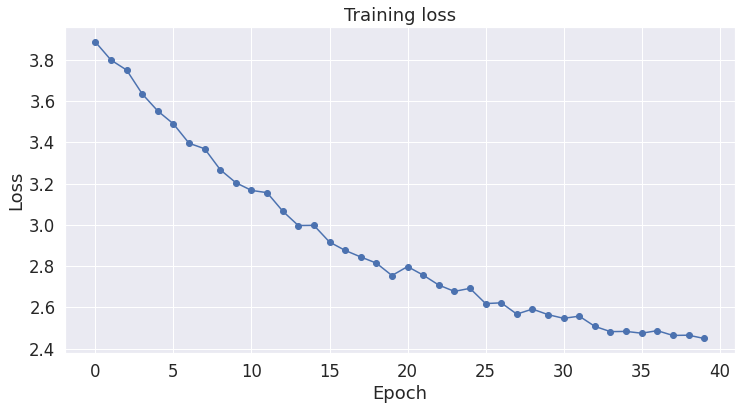

In [83]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [91]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
#the same as the maxlen we used in the encoder_plus function
MAX_LEN = max([len(sen) for sen in input_ids])
# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
# sentences = new_df.text.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 64  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [92]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print('np.shape(outputs[0]) ', np.shape(outputs[0]))
  print('np.shape(outputs[1][0]) ', np.shape(outputs[1][0]))
  print('np.shape(outputs[1][1]) ', np.shape(outputs[1][1]))
  print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 46 test sentences...
np.shape(outputs[0])  torch.Size([46, 46])
np.shape(outputs[1][0])  torch.Size([46, 256, 768])
np.shape(outputs[1][1])  torch.Size([46, 256, 768])
np.shape(outputs[1][12])  torch.Size([46, 256, 768])
    DONE.


In [93]:
from sklearn.metrics.pairwise import cosine_similarity
last_layer = outputs[1][12]
# print out all the sentences
c = 0
for doc in sentences:
  print('doc {} :'.format(c), doc)
  c += 1



doc 0 : WASHINGTON — Congressional Republicans have a new fear when it comes to their two-year-old health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for low- and moderate-income Americans, handing House Republicans a big victory on separation-of-power issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care 

In [98]:
print('-------------------------------------------------------')
i = 40 # the id of the document
print('Sentece {}: '.format(i), sentences[i])
print('Sentece {} after Tokenizing '.format(i), tokenizer.tokenize(sentences[i]))
print('Ids for each tokens :', b_input_ids[i])
word = 88 # amazon inedx in sentence 9
print('The chosen word is ', tokenizer.tokenize(sentences[i])[word-1])

# def find_similar(sentence, word_):
#   score_vector = list()
#   for tok in sentence:
#     score_vector.append(cosine_similarity([word_.to('cpu').numpy()], [tok.to('cpu').numpy()])[0][0])
#   return score_vector

# score = find_similar(last_layer[i], last_layer[i][word])
# print(score)

def find_similar(embedding_layers, word_index, original_sentence):
  score_dic = dict()
  print(len(original_sentence))
  for j in range(1, min(256, len(original_sentence))):
    score_dic[original_sentence[j -1]] =  cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]
    # print('word is {}, score is {}'.format(original_sentence[j -1], cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]))
  return score_dic

print(find_similar(last_layer[i], word,  tokenizer.tokenize(sentences[i])))
print(sorted(find_similar(last_layer[i], word,  tokenizer.tokenize(sentences[i])).items(), key=lambda kv: kv[1], reverse=True))

-------------------------------------------------------
Sentece 40:  WASHINGTON — President-elect Donald J. Trump lashed out at Democrats on Thursday over their efforts to preserve President Obama’s health care coverage law, insulting their top legislative leader and denouncing the measure as a “lie” as he called for a less expensive and more effective system. “The Democrats, lead by head clown Chuck Schumer, know how bad ObamaCare is and what a mess they are in,” Mr. Trump wrote in the first of three early-morning posts on Twitter. The posts arrived the day after Mr. Obama huddled with Democrats on Capitol Hill to strategize over protecting the Affordable Care Act and Vice President-elect Mike Pence met with Republicans about how to gut it. “Instead of working to fix it, they do the typical political thing and BLAME,” Mr. Trump continued on Twitter. “The fact is ObamaCare was a lie from the beginning. ‘Keep you doctor, keep your plan!’” He said it was time for Republicans and Democrat

In [95]:
# show th t-SNE for the tokens
from sklearn.manifold import TSNE
def tsne_plot(sentences, output):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, embed in zip(sentences, output):
        tokens.append(embed)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

(46, 256, 768)
(256,)


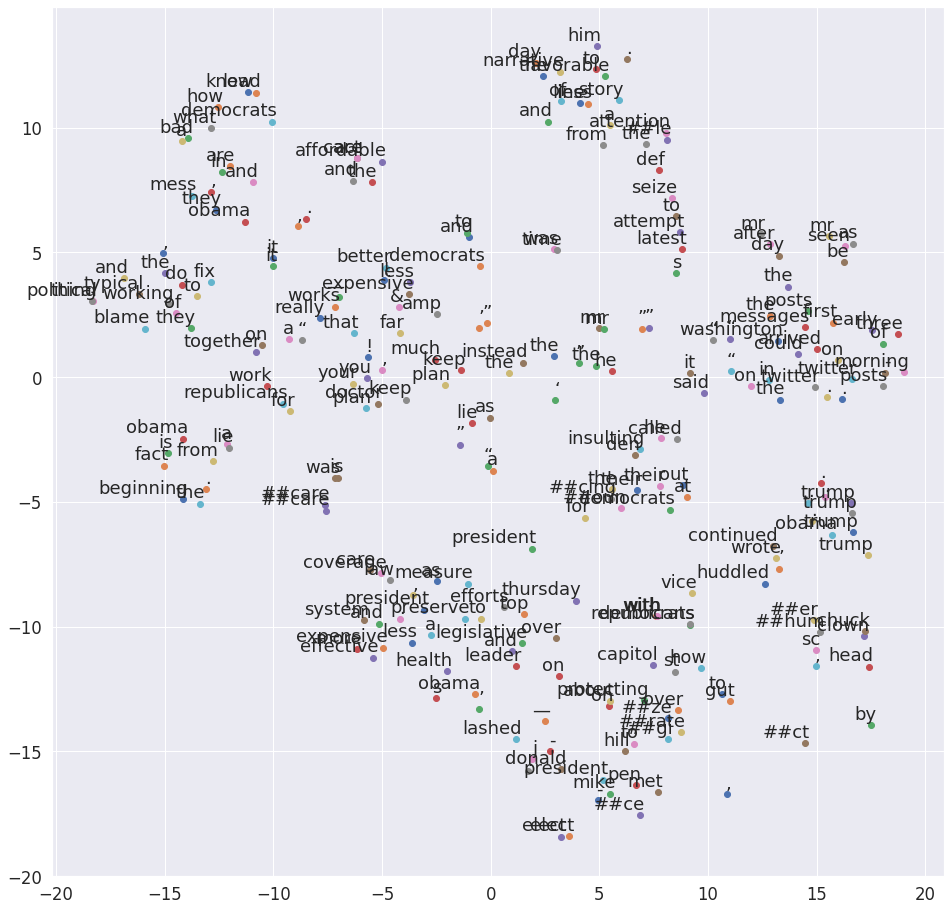

In [96]:
j = i
embedding = last_layer.to('cpu').numpy()
# embedding = outputs[1][0].to('cpu').numpy()    outputs[1][12] equales to last_later 
print(np.shape(embedding))
print(np.shape(tokenizer.tokenize(sentences[j])[0:np.shape(embedding)[1]]))

tsne_plot(tokenizer.tokenize(sentences[j])[0:np.shape(embedding)[1]], embedding[j])